# Zero-Cost NAS Examples

In this notebook, we provide examples of how to use zero-cost proxies within NAS algorithms. Specifically, we provide implementations of **random search** and **aging evolution search** with and without zero-cost warmup and move proposal.

_note: the results in our ICLR paper were produced by a different (internal) AutoML tool that we are not publicly releasing. While it should be possible to get this notebook to exactly match our tool, we haven't done that here. We just provide examples to showcase the possible advantages of using zero-cost proxies._

In [118]:
from nas_201_api import NASBench201API as API
api = API('../data/NAS-Bench-201-v1_0-e61699.pth')
api.verbose = False

try to create the NAS-Bench-201 api from ../data/NAS-Bench-201-v1_0-e61699.pth


In [119]:
import pickle
synflow_proxy=[]
f = open('../results_release/nasbench2/nb2_cf100_seed42_dlrandom_dlinfo1_initwnone_initbnone.p','rb')
while(1):
    try:
        d = pickle.load(f)
        synflow_proxy.append(d['logmeasures']['synflow'])
    except EOFError:
        break
f.close()
print(len(synflow_proxy))

15625


In [120]:
#dicts to map from index to spec or spec to index
#spec is the model description within NAS, in our case we use an encoding [5, 5, 5, 5, 5, 5]
#this is a length-6 vector, with each entry having a value between 0-4 
#this is sufficient to describe any NAS-Bench-201 cell

_opname_to_index = {
    'none': 0,
    'skip_connect': 1,
    'nor_conv_1x1': 2,
    'nor_conv_3x3': 3,
    'avg_pool_3x3': 4
}

def get_spec_from_arch_str(arch_str):
    nodes = arch_str.split('+')
    nodes = [node[1:-1].split('|') for node in nodes]
    nodes = [[op_and_input.split('~')[0]  for op_and_input in node] for node in nodes]

    spec = [_opname_to_index[op] for node in nodes for op in node]
    return spec

idx_to_spec = {}
for i, arch_str in enumerate(api):
    idx_to_spec[i] = get_spec_from_arch_str(arch_str)

spec_to_idx = {}
for idx,spec in idx_to_spec.items():
    spec_to_idx[str(spec)] = idx

In [121]:
import random
import copy
random.seed = 1
def random_spec():
    return random.choice(list(idx_to_spec.values()))

def mutate_spec(old_spec):
    idx_to_change = random.randrange(len(old_spec))
    entry_to_change = old_spec[idx_to_change]
    possible_entries = [x for x in range(5) if x != entry_to_change]
    new_entry = random.choice(possible_entries)
    new_spec = copy.copy(old_spec)
    new_spec[idx_to_change] = new_entry
    return new_spec

def mutate_spec_zero_cost(old_spec):
    possible_specs = []
    for idx_to_change in range(len(old_spec)): 
        entry_to_change = old_spec[idx_to_change]
        possible_entries = [x for x in range(5) if x != entry_to_change]
        for new_entry in possible_entries:
            new_spec = copy.copy(old_spec)
            new_spec[idx_to_change] = new_entry
            possible_specs.append((synflow_proxy[spec_to_idx[str(new_spec)]], new_spec))
    best_new_spec = sorted(possible_specs, key=lambda i:i[0])[-1][1]
    if random.random() > 0.75:
        best_new_spec = random.choice(possible_specs)[1]
    return best_new_spec

In [122]:
def random_combination(iterable, sample_size):
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), sample_size))
    return tuple(pool[i] for i in indices)

In [123]:
def crossover(parent1, parent2):
    # Try multiple cut points and select the best
    best_child = None
    best_proxy_score = float('-inf')
    num_cut_points = min(len(parent1), len(parent2)) - 1
    def update_best_child(child, best_score, current_best_child):
        child_synflow_proxy = synflow_proxy[spec_to_idx[str(child)]]
        # Update the best child if necessary
        if child_synflow_proxy > best_score:
            current_best_child = child
            best_score = child_synflow_proxy
        
        return best_score, current_best_child

    for cut_point in range(1, num_cut_points):
        # Perform cut-point crossover
        child1 = parent1[:cut_point] + parent2[cut_point:]
        best_proxy_score, best_child = update_best_child(child1, best_proxy_score, best_child)
        child2 = parent2[:cut_point] + parent1[cut_point:]
        best_proxy_score, best_child = update_best_child(child2, best_proxy_score, best_child)

    return best_child

In [124]:
def set_zero_cost_warmup(zero_cost_warmup):
    zero_cost_pool = []
    for _ in range(zero_cost_warmup):
        spec = random_spec()
        spec_idx = spec_to_idx[str(spec)]
        zero_cost_pool.append((synflow_proxy[spec_idx], spec))
        zero_cost_pool = sorted(zero_cost_pool, key=lambda i:i[0], reverse=True)
    return zero_cost_pool

In [125]:
def run_evolution_search(max_trained_models=3000, 
                         pool_size=64, 
                         tournament_size=10, 
                         zero_cost_warmup=0, 
                         zero_cost_move=False,
                         crossover_rate=0,
                         proxy_regularizer=False):
    
    best_valids, best_tests = [0.0], [0.0]
    pool = []   # (validation, spec) tuples
    num_trained_models = 0

    # fill the initial pool
    if zero_cost_warmup > 0:
        zero_cost_pool = []
        for _ in range(zero_cost_warmup):
            spec = random_spec()
            spec_idx = spec_to_idx[str(spec)]
            zero_cost_pool.append((synflow_proxy[spec_idx], spec))
            zero_cost_pool = sorted(zero_cost_pool, key=lambda i:i[0], reverse=True)
    for i in range(pool_size):
        if zero_cost_warmup > 0:
            spec = zero_cost_pool[i][1]
        else:
            spec = random_spec()
        info = api.get_more_info(spec_to_idx[str(spec)], 'cifar100', iepoch=None, hp='200', is_random=False)
        num_trained_models += 1
        pool.append((info['train-accuracy'], spec))

        if info['train-accuracy'] > best_valids[-1]:
            best_valids.append(info['train-accuracy'])
        else:
            best_valids.append(best_valids[-1])
            
        if info['test-accuracy'] > best_tests[-1]:
            best_tests.append(info['test-accuracy'])
        else:
            best_tests.append(best_tests[-1])

    # After the pool is seeded, proceed with evolving the population.
    while(1):
        # Crossover operation
        if random.random() < crossover_rate:
            parent1, parent2 = random.sample(pool, 2)
            new_spec = crossover(parent1[1], parent2[1])
        else:
            sample = random_combination(pool, tournament_size)
            best_spec = sorted(sample, key=lambda i:i[0])[-1][1]
            if zero_cost_move:
                new_spec = mutate_spec_zero_cost(best_spec)
            else:
                new_spec = mutate_spec(best_spec)

        info = api.get_more_info(spec_to_idx[str(new_spec)], 'cifar100', iepoch=None, hp='200', is_random=False)
        num_trained_models += 1

        pool.append((info['train-accuracy'], new_spec))
        if proxy_regularizer:
            proxy_scores = {}
            min_proxy_score = float("inf")
            for individual in pool:
                individual_spec = spec_to_idx[str(individual[1])]
                individual_proxy_score = synflow_proxy[individual_spec]
                proxy_scores[individual_spec] = individual_proxy_score
                # update the minimum proxy score
                if individual_proxy_score < min_proxy_score:
                    min_proxy_score = individual_proxy_score
            # keep in the pool only individuals with bigger proxy score than min_proxy_score
            pool = [individual for individual in pool if proxy_scores[spec_to_idx[str(individual[1])]] > min_proxy_score]
        else:
            # kill the oldest individual in the population
            pool.pop(0)

        if info['train-accuracy'] > best_valids[-1]:
            best_valids.append(info['train-accuracy'])
        else:
            best_valids.append(best_valids[-1])
            
        if info['test-accuracy'] > best_tests[-1]:
            best_tests.append(info['test-accuracy'])
        else:
            best_tests.append(best_tests[-1])

        if num_trained_models >= max_trained_models:
            break
    best_tests.pop(0)
    best_valids.pop(0)
    return best_valids, best_tests

In [126]:
def run_random_search(max_trained_models=3000, 
                      zero_cost_warmup=0):
    
    best_valids, best_tests = [0.0], [0.0]
    pool = []   # (validation, spec) tuples
    num_trained_models = 0

    # fill the initial pool
    if zero_cost_warmup > 0:
        zero_cost_pool = []
        for _ in range(zero_cost_warmup):
            spec = random_spec()
            spec_idx = spec_to_idx[str(spec)]
            zero_cost_pool.append((synflow_proxy[spec_idx], spec))
            zero_cost_pool = sorted(zero_cost_pool, key=lambda i:i[0], reverse=True)
    for i in range(max_trained_models):
        if i < zero_cost_warmup:
            spec = zero_cost_pool[i][1]
        else:
            spec = random_spec()
        info = api.get_more_info(spec_to_idx[str(spec)], 'cifar100', iepoch=None, hp='200', is_random=False)

        if info['valid-accuracy'] > best_valids[-1]:
            best_valids.append(info['valid-accuracy'])
        else:
            best_valids.append(best_valids[-1])
            
        if info['test-accuracy'] > best_tests[-1]:
            best_tests.append(info['test-accuracy'])
        else:
            best_tests.append(best_tests[-1])
            
    best_tests.pop(0)
    best_valids.pop(0)
    return best_valids, best_tests

In [317]:
from tqdm import tqdm
num_rounds = 10
length = 50
ae, ae_warmup, ae_move, ae_warmup_move, ae_crossover_warmup, ae_crossover, rand, rand_warmup = [], [], [], [], [], [], [], []

ae_crossover3_warmup, ae_crossover8_warmup = [], []

ae_proxy_regularizer = []
ae_warmup_proxy_regularizer = []
ae_warmup_crossover_proxy_regularizer = []
ae_warmup_crossover_mutation_proxy_regularizer = []
for _ in tqdm(range(num_rounds)):
    # simple ae
    ae_best_valids, ae_best_tests = run_evolution_search(max_trained_models=length)
    ae.append(ae_best_tests)
    # ae + warmup
    ae_warmup_best_valids, ae_warmup_best_tests = run_evolution_search(max_trained_models=length, zero_cost_warmup=3000)
    ae_warmup.append(ae_warmup_best_tests)
    # ae + move
    ae_move_best_valids, ae_move_best_tests = run_evolution_search(max_trained_models=length, zero_cost_move=True)
    ae_move.append(ae_move_best_tests)
    # ae + warmup + move
    ae_warmup_move_best_valids, ae_warmup_move_best_tests = run_evolution_search(max_trained_models=length, zero_cost_warmup=3000, zero_cost_move=True)
    ae_warmup_move.append(ae_warmup_move_best_tests)
    # ae + crossover
    ae_crossover_best_valids, ae_crossover_best_tests = run_evolution_search(max_trained_models=length, crossover_rate=0.5)
    ae_crossover.append(ae_crossover_best_tests)
    # ae + warmup + crossover rate=0.5
    ae_warmup_crossover_best_valids, ae_warmup_crossover_best_tests = run_evolution_search(max_trained_models=length, zero_cost_warmup=3000, crossover_rate=0.5)
    ae_crossover_warmup.append(ae_warmup_crossover_best_tests)
    # ae + warmup + crossover rate=0.3
    ae_warmup_crossover_best_valids, ae_warmup_crossover_best_tests = run_evolution_search(max_trained_models=length, zero_cost_warmup=3000, crossover_rate=0.3)
    ae_crossover3_warmup.append(ae_warmup_crossover_best_tests)
    # ae + warmup + crossover rate=0.8
    ae_warmup_crossover_best_valids, ae_warmup_crossover_best_tests = run_evolution_search(max_trained_models=length, zero_cost_warmup=3000, crossover_rate=0.8)
    ae_crossover8_warmup.append(ae_warmup_crossover_best_tests)
    # ae + proxy_regularizer
    ae_proxy_regularizer_best_valids, ae_proxy_regularizer_best_tests = run_evolution_search(max_trained_models=length, proxy_regularizer=True)
    ae_proxy_regularizer.append(ae_proxy_regularizer_best_tests)
    # ae + warmup + proxy
    ae_warmup_proxy_regularizer_best_valids, ae_warmup_proxy_regularizer_best_tests = run_evolution_search(max_trained_models=length, zero_cost_warmup=3000, proxy_regularizer=True)
    ae_warmup_proxy_regularizer.append(ae_warmup_proxy_regularizer_best_tests)
    # ae + warmup + crossover + proxy
    ae_warmup_crossover_proxy_regularizer_best_valids, ae_warmup_crossover_proxy_regularizer_best_tests = run_evolution_search(max_trained_models=length, zero_cost_warmup=3000,  crossover_rate=0.5, proxy_regularizer=True)
    ae_warmup_crossover_proxy_regularizer.append(ae_warmup_crossover_proxy_regularizer_best_tests)
    # ae + warmup + crossover + mutation + proxy
    ae_warmup_crossover_mutation_proxy_regularizer_best_valids, ae_warmup_crossover_mutation_proxy_regularizer_best_tests = run_evolution_search(max_trained_models=length, zero_cost_warmup=3000, zero_cost_move=True, crossover_rate=0.5, proxy_regularizer=True)
    ae_warmup_crossover_mutation_proxy_regularizer.append(ae_warmup_crossover_mutation_proxy_regularizer_best_tests)
    # random search
    rand_best_valids, rand_best_tests = run_random_search(max_trained_models=length)
    rand.append(rand_best_tests)
    rand_warmup_best_valids, rand_warmup_best_tests = run_random_search(max_trained_models=length, zero_cost_warmup=3000)
    rand_warmup.append(rand_warmup_best_tests)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:01<00:00,  6.14s/it]


In [318]:
import matplotlib.pyplot as plt
import numpy as np

def plot_experiment(exp_list, title):
    def plot_exp(exp, label):
        exp = np.array(exp) 
        q_75 = np.quantile(exp, .75, axis=0)
        q_25 = np.quantile(exp, .25, axis=0)
        mean = np.mean(exp, axis=0)
        plt.plot(mean, label=label)
        plt.fill_between(range(len(q_25)), q_25, q_75, alpha=0.1)
    for exp,ename in exp_list:
        plot_exp(exp,ename)
    plt.grid()
    plt.xlabel('Trained models')
    plt.ylabel('Average test accuracies')
    plt.ylim(70,73.6)
    plt.xlim(0, 50)
    plt.legend()
    plt.title(title)
    plt.show()

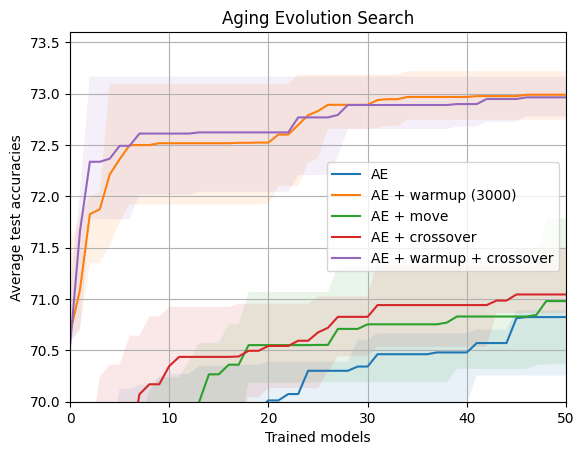

In [319]:
plot_experiment([(ae,'AE'), (ae_warmup,'AE + warmup (3000)'), (ae_move,'AE + move'), (ae_crossover, "AE + crossover"), (ae_crossover_warmup, "AE + warmup + crossover")], 'Aging Evolution Search')


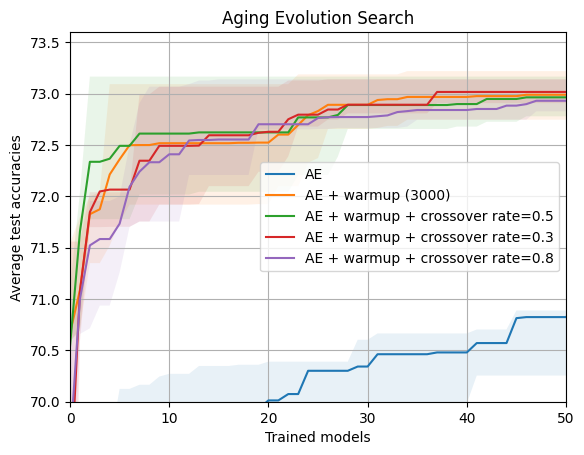

In [320]:
plot_experiment([(ae,'AE'), (ae_warmup,'AE + warmup (3000)'), (ae_crossover_warmup, "AE + warmup + crossover rate=0.5"), (ae_crossover3_warmup, "AE + warmup + crossover rate=0.3"), (ae_crossover8_warmup, "AE + warmup + crossover rate=0.8")], 'Aging Evolution Search')

## Proxy regularizer

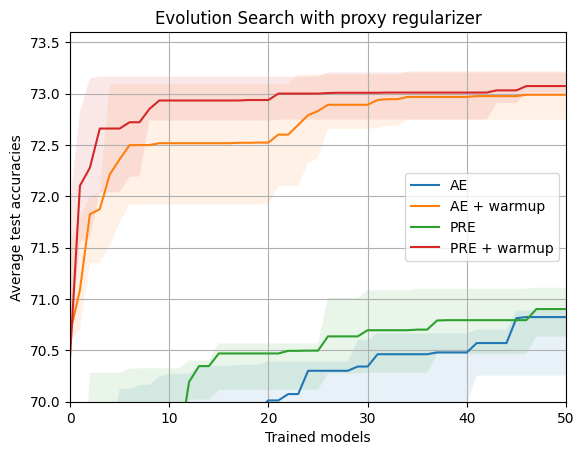

In [323]:
plot_experiment([(ae, "AE"), (ae_warmup, "AE + warmup"), (ae_proxy_regularizer, "PRE"), (ae_warmup_proxy_regularizer, "PRE + warmup")], "Evolution Search with proxy regularizer")

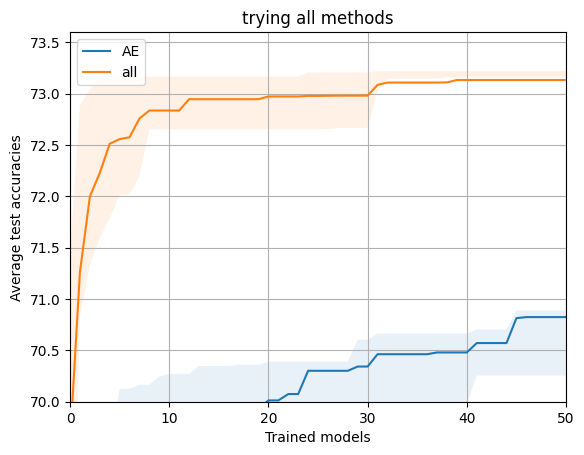

In [322]:
plot_experiment([(ae, "AE"), (ae_warmup_crossover_mutation_proxy_regularizer, "all")], "trying all methods")